 ## Check Data

In [1]:
import obspy
import matplotlib.pyplot as plt

from obspy.clients.filesystem.sds import Client

### configurations

In [48]:
config = {}

config['tbeg'] = obspy.UTCDateTime("2023-03-16 00:50")
config['tend'] = obspy.UTCDateTime("2023-03-16 03:30")

config['client'] = Client("/import/freenas-ffb-01-data/ModalAnalysis/data/SDS")  

config['seed'] = "XX.RY??..HH*"

config['stations'] = ['RY01','RY02','RY03','RY04','RY05','RY06','RY07','RY08','RY09','RY10']

config['inventories'] = "/import/freenas-ffb-01-data/ModalAnalysis/data/StationXML/"

### load data

In [55]:
def __get_data_all(config):
    
    from tqdm.notebook import tqdm
    
    net, sta, loc, cha = config['seed'].split(".")

    st0 = obspy.Stream()
    
    for sta in tqdm(config['stations']):

        try:
            st = config['client'].get_waveforms(network=net, station=sta, location=loc, channel=cha, 
                                                starttime=config['tbeg'], endtime=config['tend'])

            if len(st) == 0:
                raise "no data in stream"
            
            inv = obspy.read_inventory(config['inventories']+f"XX.{sta}.xml")


            st = st.remove_response(inventory=inv, output="VEL", water_level=60, plot=False) 
            
            st.merge()
            
            st0 += st

        except:
            print(f" -> loading failed for: {sta}")
                
    return st0

In [56]:
st0 = __get_data_all(config)

  0%|          | 0/3 [00:00<?, ?it/s]

 -> loading failed for: RY09
 -> loading failed for: RY10


/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


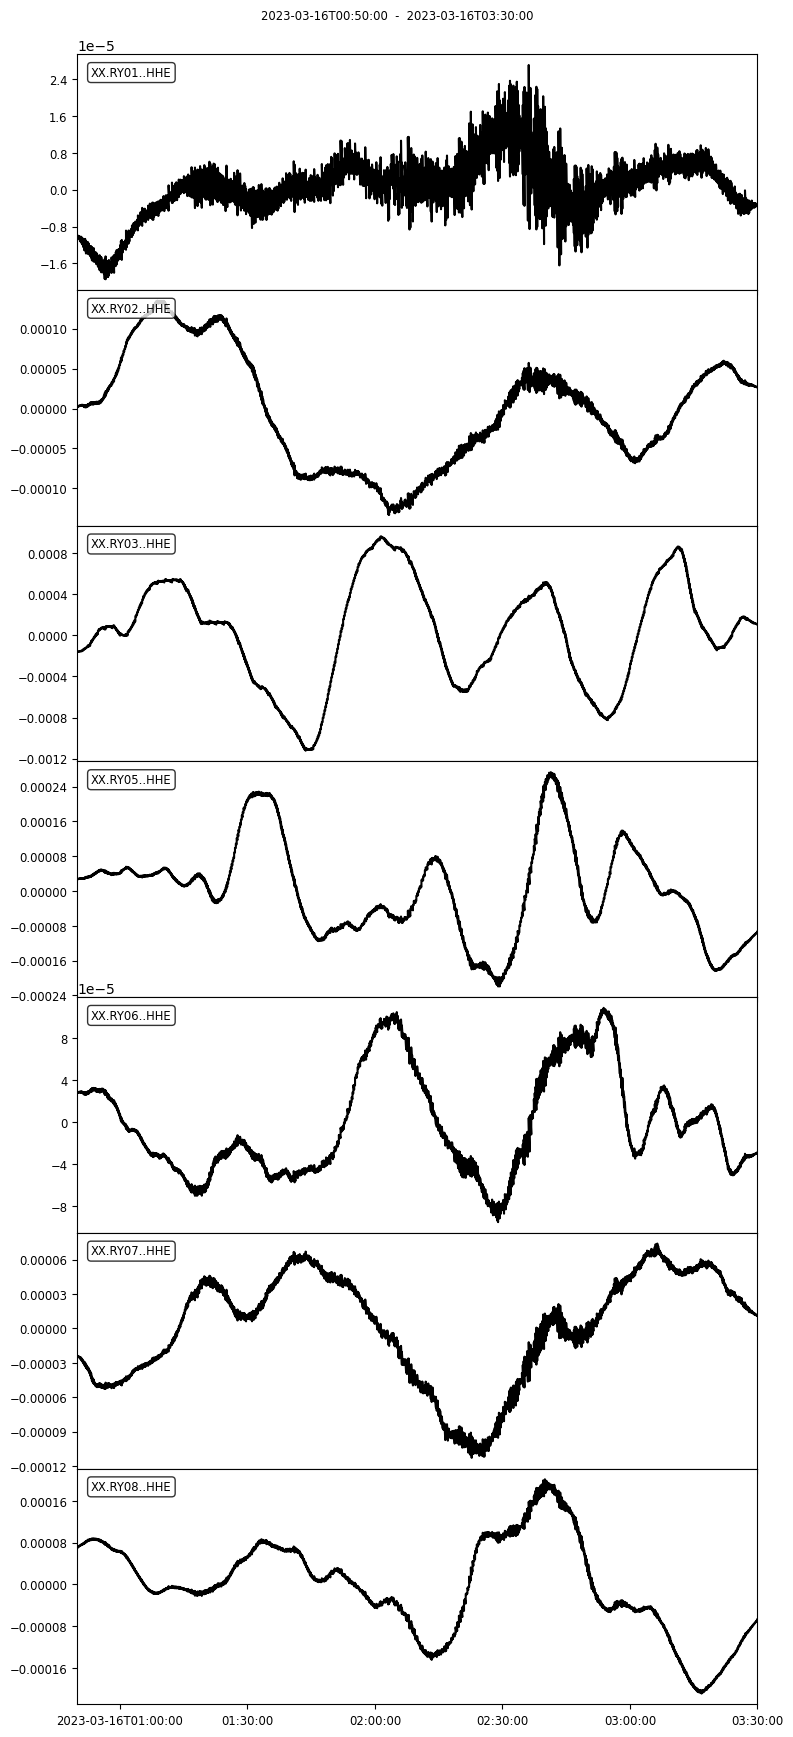

/home/brotzer/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


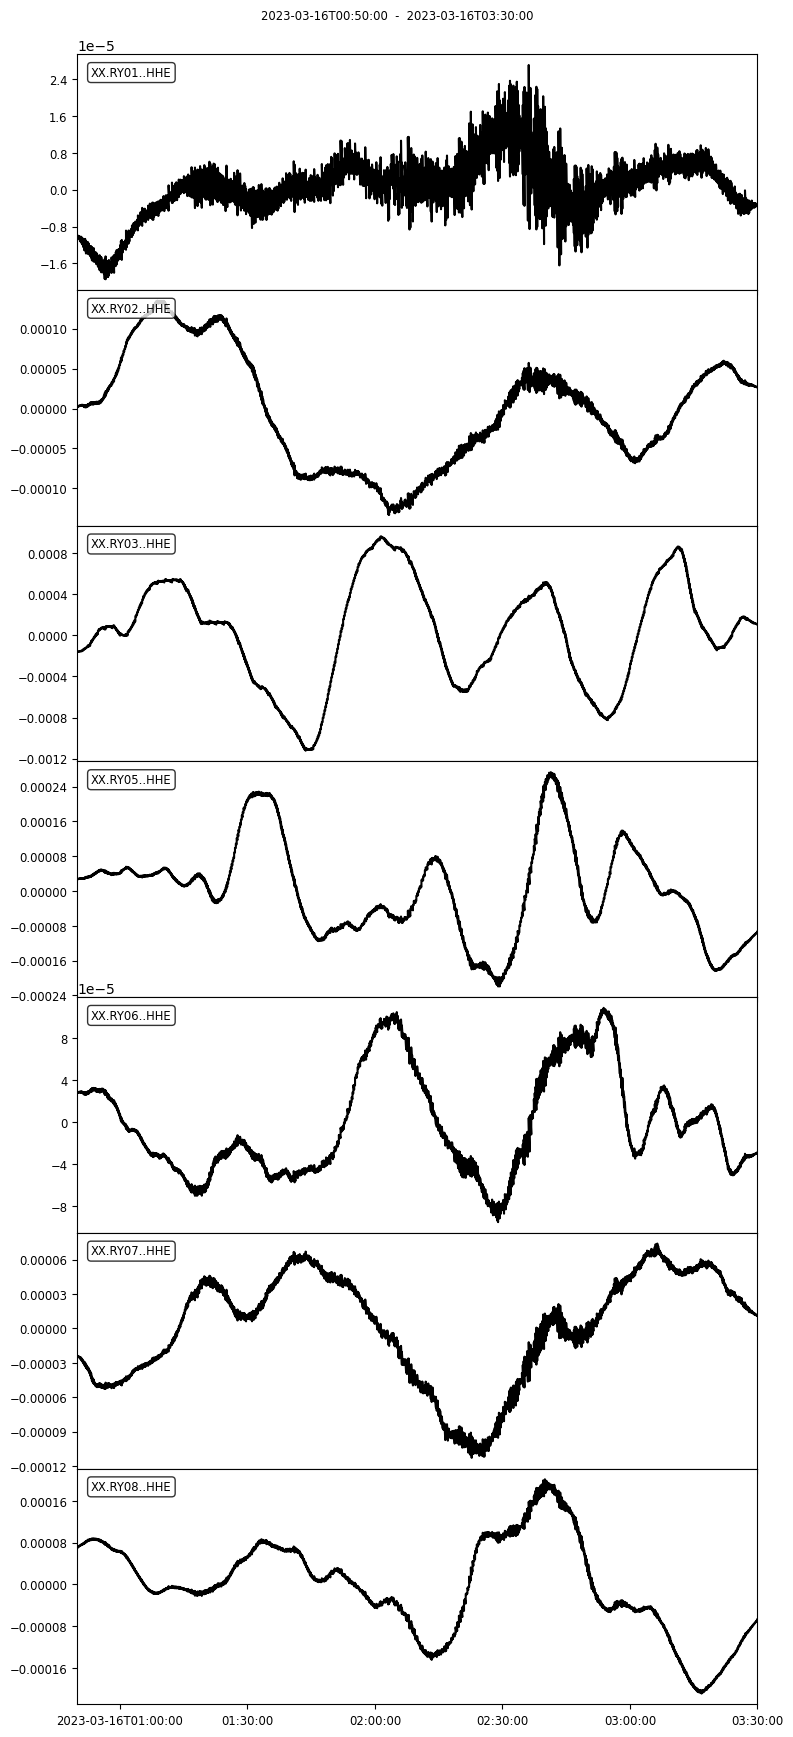

In [43]:
st0 = st0.merge()
st0.select(channel="*E").plot(equal_scale=False)

In [57]:
st = st0.copy()

st = st.detrend('demean')

st = st.taper(0.1)

st = st.filter('bandpass', freqmin=0.05, freqmax=.5, corners=4, zerophase=True)

/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/brotzer/anaconda3/lib/python3.7/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


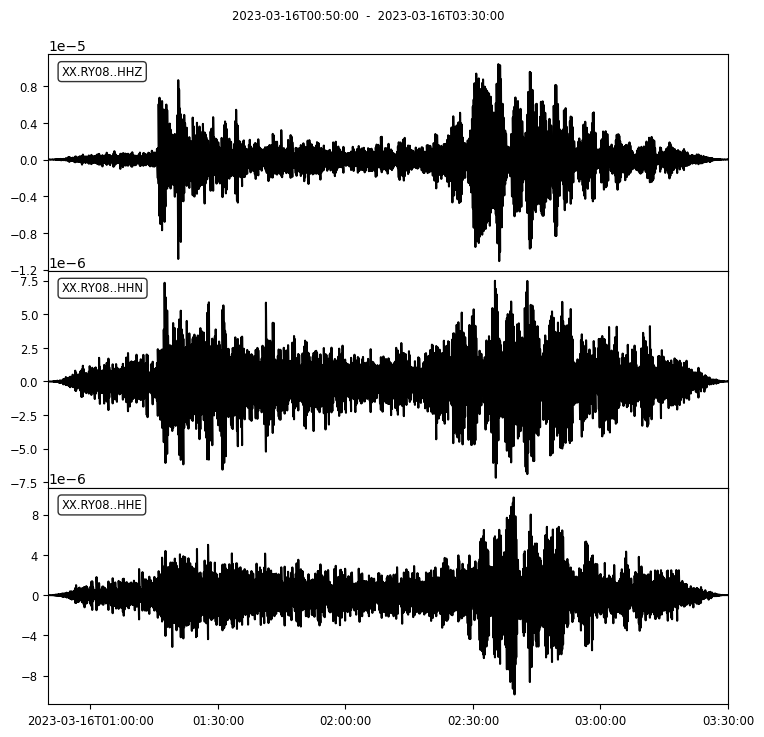

In [58]:
st.plot(equal_scale=False);